### Importing stuff

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from typing import *
import os
import random
import datetime
import time

### Loading data

In [2]:
market_data_files = [ 
    "../data/ml_data/market2_traders.csv",
    "../data/ml_data/market1_no_traders.csv",
    "../data/ml_data/round0_match.csv"
]
save_for_later_file = [
    "../data/ml_data/market3_traders.csv"
]

In [3]:
columns = ['MidPriceETF', 'LastTradedPriceETF',
       'MidPriceFUT', 'LastTradedPriceFUT', 'ETF_BID_PRICE_0',
       'ETF_BID_PRICE_1', 'ETF_BID_PRICE_2', 'ETF_BID_PRICE_3',
       'ETF_BID_PRICE_4', 'ETF_BID_VOL_0', 'ETF_BID_VOL_1', 'ETF_BID_VOL_2',
       'ETF_BID_VOL_3', 'ETF_BID_VOL_4', 'ETF_ASK_PRICE_0', 'ETF_ASK_PRICE_1',
       'ETF_ASK_PRICE_2', 'ETF_ASK_PRICE_3', 'ETF_ASK_PRICE_4',
       'ETF_ASK_VOL_0', 'ETF_ASK_VOL_1', 'ETF_ASK_VOL_2', 'ETF_ASK_VOL_3',
       'ETF_ASK_VOL_4']

In [4]:
def load_market_data_files_to_df_list() -> List[pd.DataFrame]:
    all_dfs = []
    
    for market_file_name in market_data_files:
        # we make sure that we're only reading rows where the last traded prices aren't 0
        df = pd.read_csv(market_file_name, index_col="Index").iloc[30:].drop(columns=["Unnamed: 0", "Time"])
        df.index = df.index.astype(int)
        for column in df.columns:
            assert df[column].isnull().values.any() == False
        assert len(df[df["LastTradedPriceETF"] == 0]) == 0
        assert len(df[df["LastTradedPriceFUT"] == 0]) == 0
        all_dfs.append(df)
    
    return all_dfs

In [5]:
dfs = load_market_data_files_to_df_list()

In [6]:
dfs[0].head(50)

MidPriceETF  LastTradedPriceETF  MidPriceFUT  LastTradedPriceFUT  \
Index                                                                     
30        148900.0            148800.0     148650.0            148800.0   
31        148900.0            148800.0     148750.0            148800.0   
32        148900.0            148800.0     148750.0            148800.0   
33        148900.0            148800.0     148650.0            148800.0   
34        148900.0            148800.0     148650.0            148800.0   
35        148700.0            148500.0     148650.0            148800.0   
36        148700.0            148500.0     148650.0            148800.0   
37        148750.0            148500.0     148650.0            148800.0   
38        148750.0            148500.0     148650.0            148800.0   
39        149050.0            148800.0     149050.0            149000.0   
40        149050.0            148800.0     148950.0            148900.0   
41        149050.0            149100.0     149000.0            148900.0   
42        149000.0            149100.0     149150.0            148900.0   
43        149000.0            149100.0     149150.0            148900.0   
44        149050.0            149100.0     149150.0            148900.0   
45        149050.0            149100.0     149150.0            148900.0   
46        149050.0            149100.0     149100.0            148900.0   
47        149050.0            149100.0     149100.0            148900.0   
48        149000.0            148800.0     149100.0            148900.0   
49        148950.0            148800.0     149000.0            149000.0   
50        148950.0            148800.0     148950.0            149000.0   
51        148950.0            148800.0     148850.0            148800.0   
52        148850.0            148800.0     148900.0            148800.0   
53        148850.0            148800.0     148900.0            148800.0   
54        148850.0            148800.0     148900.0            148800.0   
55        148900.0            148800.0     148900.0            148800.0   
56        148900.0            148800.0     149050.0            148800.0   
57        149000.0            148800.0     149000.0            148800.0   
58        149000.0            148800.0     148950.0            148800.0   
59        149000.0            148800.0     148900.0            148800.0   
60        148900.0            148800.0     148900.0            148800.0   
61        148900.0            148800.0     148900.0            148800.0   
62        148850.0            148800.0     148850.0            148800.0   
63        148850.0            148800.0     148850.0            148800.0   
64        148850.0            148800.0     148850.0            148800.0   
65        148850.0            148800.0     148900.0            148800.0   
66        148850.0            148700.0     148850.0            148800.0   
67        148800.0            148700.0     148800.0            148800.0   
68        148800.0            148700.0     148800.0            148800.0   
69        148800.0            148700.0     148800.0            148800.0   
70        148800.0            148700.0     148900.0            148800.0   
71        148800.0            148700.0     148900.0            148800.0   
72        148900.0            148700.0     148900.0            148800.0   
73        148900.0            148700.0     149000.0            148800.0   
74        148950.0            148700.0     149100.0            148800.0   
75        148950.0            148700.0     149250.0            148800.0   
76        148950.0            148700.0     149250.0            148800.0   
77        149100.0            149200.0     149200.0            149200.0   
78        149100.0            149200.0     149250.0            149200.0   
79        149150.0            149200.0     149200.0            149200.0   

       ETF_BID_PRICE_0  ETF_BID_PRICE_1  ETF_BID_PRICE_2  ETF_BID_PRICE_3  \
Index                        

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_1341/4089619651.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dfs[2]["MidPriceETF"][10:100].plot()
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_1341/4089619651.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dfs[2]["MidPriceFUT"][10:100].plot()


<AxesSubplot: xlabel='Index'>

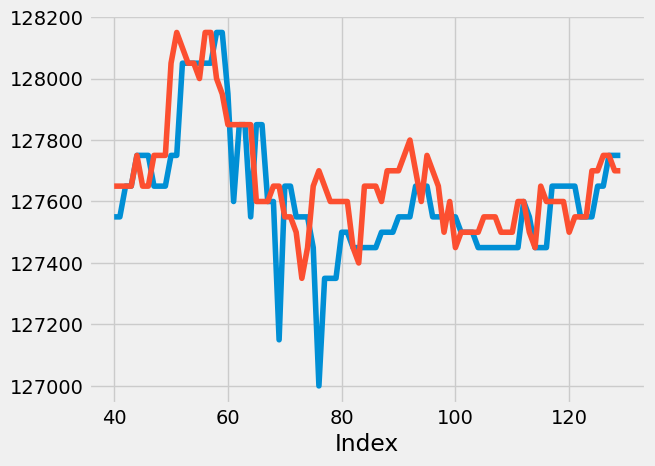

In [7]:
dfs[2]["MidPriceETF"][10:100].plot()
dfs[2]["MidPriceFUT"][10:100].plot()

In [8]:
dfs[0].columns

Index(['MidPriceETF', 'LastTradedPriceETF', 'MidPriceFUT',
       'LastTradedPriceFUT', 'ETF_BID_PRICE_0', 'ETF_BID_PRICE_1',
       'ETF_BID_PRICE_2', 'ETF_BID_PRICE_3', 'ETF_BID_PRICE_4',
       'ETF_BID_VOL_0', 'ETF_BID_VOL_1', 'ETF_BID_VOL_2', 'ETF_BID_VOL_3',
       'ETF_BID_VOL_4', 'ETF_ASK_PRICE_0', 'ETF_ASK_PRICE_1',
       'ETF_ASK_PRICE_2', 'ETF_ASK_PRICE_3', 'ETF_ASK_PRICE_4',
       'ETF_ASK_VOL_0', 'ETF_ASK_VOL_1', 'ETF_ASK_VOL_2', 'ETF_ASK_VOL_3',
       'ETF_ASK_VOL_4'],
      dtype='object')

### Feature engineering

### 3-rd place at Kaggle G-Research competition

log_return_id* : log(current Close ÷ Close before lag time)

log_close/mean_id* : log(current Close ÷ average Close during lag period)

mean_*** : Average of all currencies for the above two features

***-mean_***_id* : Difference between each currency and the average

In [71]:
for id in range(14):    
    for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = 
                np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     
            = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(14):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

SyntaxError: invalid syntax (3117510732.py, line 3)

At the moment we just take the data with a lag window of 20 ticks

In [9]:
lag_window = 20 # how much we can look back
target_ahead = 3 # 3 ticks ahead of time

In [89]:
def create_features(df) -> pd.DataFrame:
    new_df = df.copy()
    for lag in range(lag_window + 1):
        for column in df.columns:
            new_df[f'{column}_{lag}'] = df[column].shift(lag)
    new_df["target"] = df["MidPriceETF"].shift(3)
    new_df = new_df.drop(columns=df.columns)
    new_df = new_df.iloc[lag_window+1:-3]
    return new_df

In [73]:
df = dfs[0]

In [85]:
df[["MidPriceETF"]]

MidPriceETF
Index             
30        148900.0
31        148900.0
32        148900.0
33        148900.0
34        148900.0
...            ...
8995      134250.0
8996      134250.0
8997      134300.0
8998      134300.0
8999      134300.0

[8970 rows x 1 columns]

In [90]:
df.head()

MidPriceETF  LastTradedPriceETF  MidPriceFUT  LastTradedPriceFUT  \
Index                                                                     
30        148900.0            148800.0     148650.0            148800.0   
31        148900.0            148800.0     148750.0            148800.0   
32        148900.0            148800.0     148750.0            148800.0   
33        148900.0            148800.0     148650.0            148800.0   
34        148900.0            148800.0     148650.0            148800.0   

       ETF_BID_PRICE_0  ETF_BID_PRICE_1  ETF_BID_PRICE_2  ETF_BID_PRICE_3  \
Index                                                                       
30            148800.0         148600.0         148500.0         148200.0   
31            148800.0         148600.0         148500.0         148200.0   
32            148800.0         148600.0         148500.0         148200.0   
33            148800.0         148600.0         148500.0         148200.0   
34            148800.0         148600.0         148500.0         148200.0   

       ETF_BID_PRICE_4  ETF_BID_VOL_0  ...  LastTradedPriceETF_0_4_5_6_10  \
Index                                  ...                                  
30            148000.0           10.0  ...                            NaN   
31            148000.0           10.0  ...                            NaN   
32                 0.0           10.0  ...                            NaN   
33                 0.0           10.0  ...                            NaN   
34                 0.0           10.0  ...                            NaN   

       MidPriceFUT_0_4_5_6_10  LastTradedPriceFUT_0_4_5_6_10  \
Index                                                          
30                        NaN                            NaN   
31                        NaN                            NaN   
32                        NaN                            NaN   
33                        NaN                            NaN   
34                        NaN                            NaN   

       ETF_BID_PRICE_0_0_4_5_6_10  ETF_BID_PRICE_1_0_4_5_6_10  \
Index                                                           
30                            NaN                         NaN   
31                            NaN                         NaN   
32                            NaN                         NaN   
33                            NaN                         NaN   
34                            NaN                         NaN   

       ETF_BID_PRICE_2_0_4_5_6_10  ETF_BID_PRICE_3_0_4_5_6_10  \
Index                                                           
30                            NaN                         NaN   
31                            NaN                         NaN   
32                            NaN                         NaN   
33                            NaN                         NaN   
34                            NaN                         NaN   

       ETF_BID_PRICE_4_0_4_5_6_10  ETF_BID_VOL_0_0_4_5_6_10  \
Index                                                         
30                            NaN                       NaN   
31                            NaN                       NaN   
32                            NaN                       NaN   
33                            NaN                       NaN   
34                            NaN                       NaN   

       ETF_BID_VOL_1_0_4_5_6_10  
Index                            
30                          NaN  
31                          NaN  
32                          NaN  
33                          NaN  
34                          NaN  

[5 rows x 27299 columns]

In [ ]:
features = create_features(df)

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'{column}_{lag}'] = df[column].shift(lag)
/var/folders/rp/dmbbthp17vdc__2336dxqvvr0000gn/T/ipykernel_27747/476492079.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

In [83]:
features.head(2)

MidPriceETF  LastTradedPriceETF  MidPriceFUT  LastTradedPriceFUT  \
Index                                                                     
71        148800.0            148700.0     148900.0            148800.0   
72        148900.0            148700.0     148900.0            148800.0   

       ETF_BID_PRICE_0  ETF_BID_PRICE_1  ETF_BID_PRICE_2  ETF_BID_PRICE_3  \
Index                                                                       
71            148700.0         148600.0         148300.0         148200.0   
72            148800.0         148600.0         148300.0         148200.0   

       ETF_BID_PRICE_4  ETF_BID_VOL_0  ...  ETF_ASK_PRICE_1_20  \
Index                                  ...                       
71                 0.0           21.0  ...            149100.0   
72                 0.0           21.0  ...            149100.0   

       ETF_ASK_PRICE_2_20  ETF_ASK_PRICE_3_20  ETF_ASK_PRICE_4_20  \
Index                                                               
71               149200.0            149600.0            150900.0   
72               149200.0            149300.0            149500.0   

       ETF_ASK_VOL_0_20  ETF_ASK_VOL_1_20  ETF_ASK_VOL_2_20  ETF_ASK_VOL_3_20  \
Index                                                                           
71                 10.0              67.0              20.0           10070.0   
72                 50.0              17.0              20.0             113.0   

       ETF_ASK_VOL_4_20    target  
Index                              
71                 63.0  148800.0  
72              10000.0  148800.0  

[2 rows x 529 columns]

In [ ]:
features.iloc[50][""]